In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, json, codecs
import cv2 as cv
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dense, MaxPool2D, Activation, Dropout, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
np.random.seed(921)
from keras.utils import np_utils
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ImportError: cannot import name 'np_utils' from 'keras.utils' (/usr/local/lib/python3.10/dist-packages/keras/api/utils/__init__.py)

In [ ]:
# ----------------Training meta data--------------------------------
with codecs.open("/kaggle/input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_train_annotations.json",'r', encoding='utf-8', errors = 'ignore') as f :
    train_anot_meta = json.load(f)

#--------------- Testing meta data --------------------------------
with codecs.open("/kaggle/input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_test_information.json",'r', encoding='utf-8', errors='ignore') as f:
    test_anot_meta = json.load(f)

#---------------- Detection meta data--------------------------------
with codecs.open("/kaggle/input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_mdv4_detections.json",'r', encoding='utf-8', errors='ignore') as f:
    detection_data = json.load(f)

#--------------- GPS location meta data-------------------------------------
with codecs.open("/kaggle/input/iwildcam2022-fgvc9/metadata/metadata/gps_locations.json",'r', encoding='utf-8', errors='ignore') as f :
    gps_location = json.load(f)
# ("/kaggle/input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_train_annotations.json")

In [ ]:
print(f"Training anotations : {train_anot_meta.keys()}\
        \nTesting Anotation : {test_anot_meta.keys()}\
        \nGps Location : gps_location.keys()\
        \ndetection : {detection_data.keys()}")

Training anotations : dict_keys(['images', 'annotations', 'categories'])        
Testing Anotation : dict_keys(['images'])        
Gps Location : gps_location.keys()        
detection : dict_keys(['detection_categories', 'info', 'images'])


In [ ]:
# -----------------Training meta data in pandas dataframe--------------------------------
train_images = pd.DataFrame(train_anot_meta['images'])
train_anotations = pd.DataFrame(train_anot_meta['annotations'])
train_categories = pd.DataFrame(train_anot_meta['categories'])
print(f"Train images Shape : {train_images.shape}\
        \nAnnotation Shape : {train_anotations.shape}\
        \nTrain_Categories : {train_categories.shape}")

Train images Shape : (201399, 10)        
Annotation Shape : (201399, 3)        
Train_Categories : (205, 2)


In [ ]:
# -----------------Test meta data in the Pandas datarame-------------------------------------
test_images = pd.DataFrame(test_anot_meta['images'])
print(f"Test_images shape :{test_images.shape}")

Test_images shape :(60029, 10)


In [ ]:
train_images

,seq_num_frames,location,datetime,id,seq_id,width,height,file_name,sub_location,seq_frame_num
0,6,3,2013-06-05 05:44:19.000,8b02698a-21bc-11ea-a13a-137349068a90,30048d32-7d42-11eb-8fb5-0242ac1c0002,1920,1080,8b02698a-21bc-11ea-a13a-137349068a90.jpg,0.0,0
1,6,3,2013-06-05 05:44:20.000,8e5b81de-21bc-11ea-a13a-137349068a90,30048d32-7d42-11eb-8fb5-0242ac1c0002,1920,1080,8e5b81de-21bc-11ea-a13a-137349068a90.jpg,0.0,1
2,6,3,2013-06-05 05:44:21.000,8c6be0e4-21bc-11ea-a13a-137349068a90,30048d32-7d42-11eb-8fb5-0242ac1c0002,1920,1080,8c6be0e4-21bc-11ea-a13a-137349068a90.jpg,0.0,2
3,6,3,2013-06-05 05:44:22.000,8fdf7998-21bc-11ea-a13a-137349068a90,30048d32-7d42-11eb-8fb5-0242ac1c0002,1920,1080,8fdf7998-21bc-11ea-a13a-137349068a90.jpg,0.0,3
4,6,3,2013-06-05 05:44:23.000,96093c50-21bc-11ea-a13a-137349068a90,30048d32-7d42-11eb-8fb5-0242ac1c0002,1920,1080,96093c50-21bc-11ea-a13a-137349068a90.jpg,0.0,4
...,...,...,...,...,...,...,...,...,...,...
201394,6,165,2013-06-05 13:08:12.000,91421eee-21bc-11ea-a13a-137349068a90,974a375e-21bc-11ea-a13a-137349068a90,2048,1536,91421eee-21bc-11ea-a13a-137349068a90.jpg,NaN,1
201395,6,165,2013-06-05 13:08:19.000,91140194-21bc-11ea-a13a-137349068a90,974a375e-21bc-11ea-a13a-137349068a90,2048,1536,91140194-21bc-11ea-a13a-137349068a90.jpg,NaN,2
201396,6,165,2013-06-05 13:08:42.000,8f1f5f46-21bc-11ea-a13a-137349068a90,974a375e-21bc-11ea-a13a-137349068a90,2048,1536,8f1f5f46-21bc-11ea-a13a-137349068a90.jpg,NaN,3
201397,6,165,2013-06-05 13:08:48.000,974a365a-21bc-11ea-a13a-137349068a90,974a375e-21bc-11ea-a13a-137349068a90,2048,1536,974a365a-21bc-11ea-a13a-137349068a90.jpg,NaN,4


In [ ]:
train_anotations

,id,image_id,category_id
0,a292dd3c-21bc-11ea-a13a-137349068a90,96b00332-21bc-11ea-a13a-137349068a90,73
1,a0afcfc0-21bc-11ea-a13a-137349068a90,879d74d8-21bc-11ea-a13a-137349068a90,4
2,a306e9c0-21bc-11ea-a13a-137349068a90,9017f7aa-21bc-11ea-a13a-137349068a90,227
3,9eed94c4-21bc-11ea-a13a-137349068a90,90d93c58-21bc-11ea-a13a-137349068a90,250
4,a2a4dd7a-21bc-11ea-a13a-137349068a90,887cd0ec-21bc-11ea-a13a-137349068a90,2
...,...,...,...
201394,9d6654a6-21bc-11ea-a13a-137349068a90,911ef838-21bc-11ea-a13a-137349068a90,372
201395,9b4c9de2-21bc-11ea-a13a-137349068a90,8b7899a2-21bc-11ea-a13a-137349068a90,372
201396,9a379740-21bc-11ea-a13a-137349068a90,958f609c-21bc-11ea-a13a-137349068a90,372
201397,9d0a3c0c-21bc-11ea-a13a-137349068a90,93bd2ede-21bc-11ea-a13a-137349068a90,372


In [ ]:
train_categories

,id,name
0,0,empty
1,2,tayassu pecari
2,3,dasyprocta punctata
3,4,cuniculus paca
4,6,puma concolor
...,...,...
200,566,sciurus sp
201,567,ave desconocida
202,568,aramides cajanea
203,570,aramus guarauna


In [ ]:
# Let's check the number of training samles
print(f"Training Sample Length :{len(os.listdir('/kaggle/input/iwildcam2022-fgvc9/train/train'))}\
        \nTesting Sample Length :{len(os.listdir('/kaggle/input/iwildcam2022-fgvc9/test/test'))}")
# so the Number of samples are same for both training samples and for the metadata i.e. 201399

Training Sample Length :201399        
Testing Sample Length :60029


## Images of an animals

Images Shape : (1080, 1920, 3)


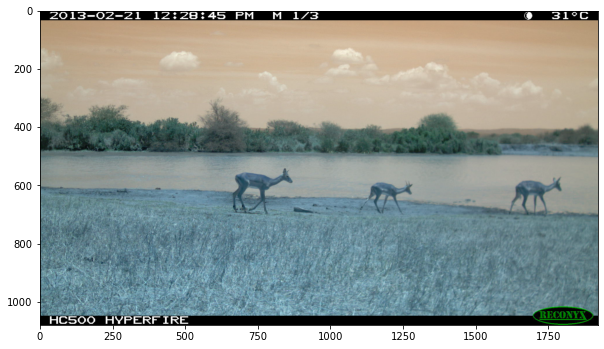

In [ ]:
# reading the first image from the training sample and showing it down.
img = cv.imread("/kaggle/input/iwildcam2022-fgvc9/train/train/86760c00-21bc-11ea-a13a-137349068a90.jpg")
print(f"Images Shape : {img.shape}")
plt.figure(figsize=(10,10))
plt.imshow(img)

In [ ]:
train_anotations['image_id']

0         96b00332-21bc-11ea-a13a-137349068a90
1         879d74d8-21bc-11ea-a13a-137349068a90
2         9017f7aa-21bc-11ea-a13a-137349068a90
3         90d93c58-21bc-11ea-a13a-137349068a90
4         887cd0ec-21bc-11ea-a13a-137349068a90
                          ...                 
201394    911ef838-21bc-11ea-a13a-137349068a90
201395    8b7899a2-21bc-11ea-a13a-137349068a90
201396    958f609c-21bc-11ea-a13a-137349068a90
201397    93bd2ede-21bc-11ea-a13a-137349068a90
201398    8971956e-21bc-11ea-a13a-137349068a90
Name: image_id, Length: 201399, dtype: object

# Resize Images

In [ ]:
#-------Taking only 20000 data from the training set-----------------
images = train_anotations.image_id[:20000]
labels = train_anotations.category_id[:20000]

#--- Reshaping the images ------------------------------
train_images = []
for i in images:
    rd_img = cv.imread("/kaggle/input/iwildcam2022-fgvc9/train/train/"+ i +".jpg")
    res_img = cv.resize(rd_img, (32,32), interpolation=cv.INTER_AREA)
    train_images.append(res_img)

# Convert it into the numpy array
train_images = np.array(train_images)

In [ ]:
# train_images

## Model Creation

In [ ]:
#-------------------- Model Creation --------------------------------------------------------
model = Sequential()

#---- 1st Convolution Layer---------
model.add(Convolution2D(filters=32, kernel_size = (3,3), input_shape=(32, 32,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate = 0.35))

#----- 1st Pooling layer-------------
model.add(MaxPool2D(pool_size = (2,2), padding='same'))

#----- 2nd Convolution Layer----------
model.add(Convolution2D(filters= 64, kernel_size=(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.45))

#------2nd pooling Layer--------------
model.add(MaxPool2D(pool_size=(2,2), padding='same'))
model.add(Flatten())

#---- 1st Dense Layer-----------------
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.75))

#------2nd Dense Layer---------------
model.add(Dense(max(labels)+1, activation='softmax'))

#---------------Model Compilation------------------------------------------
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


2023-02-01 14:10:21.864816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:10:21.865927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:10:21.978524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:10:21.979513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 14:10:21.980368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## Training Data Splitting

In [ ]:
#---------Train test split ---------------------------------
X_train, X_test, Y_train, y_test = train_test_split(train_images, labels, test_size = 0.2)

In [ ]:
#----------- Changeg datatype and reshape the data----------------
Y_train=Y_train.astype(int)
y_test=y_test.astype(int)

#---------- Reshape Y------------------
Y_train=np.array(Y_train).reshape(-1,1)
y_test=np.array(y_test).reshape(-1,1)

# -------- Reshape X ------------------
X_train=X_train.reshape(-1,32,32,3)/255
X_test=X_test.reshape(-1,32,32,3)/255

#-----------Convert it into Categorical data -------------------
Y_train=np_utils.to_categorical(Y_train,num_classes=max(labels)+1)
y_test=np_utils.to_categorical(y_test,num_classes=max(labels)+1)

## Training

In [ ]:
#------------ Train the data--------------------
train_history = model.fit(X_train,Y_train,validation_split=0.2,epochs=30,batch_size=200,verbose=1)

#----------- Calculate Accuracy --------------------
accuracy = model.evaluate(X_test,y_test,verbose=1)
print("test accuracy:",accuracy[1])

2023-02-01 14:10:27.356559: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 157286400 exceeds 10% of free system memory.
2023-02-01 14:10:27.599475: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 157286400 exceeds 10% of free system memory.
2023-02-01 14:10:27.736213: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 17971200 exceeds 10% of free system memory.
2023-02-01 14:10:27.783874: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-02-01 14:10:29.893076: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


64/64 [==============================] - ETA: 0s - loss: 2.2089 - accuracy: 0.5082

2023-02-01 14:10:38.854303: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 39321600 exceeds 10% of free system memory.
2023-02-01 14:10:38.917164: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 39321600 exceeds 10% of free system memory.


64/64 [==============================] - 11s 21ms/step - loss: 2.2089 - accuracy: 0.5082 - val_loss: 4.9903 - val_accuracy: 0.1325
Epoch 2/30
64/64 [==============================] - 1s 15ms/step - loss: 1.4010 - accuracy: 0.6279 - val_loss: 4.6169 - val_accuracy: 0.0538
Epoch 3/30
64/64 [==============================] - 1s 16ms/step - loss: 1.1643 - accuracy: 0.6811 - val_loss: 4.0149 - val_accuracy: 0.2306
Epoch 4/30
64/64 [==============================] - 1s 14ms/step - loss: 1.0124 - accuracy: 0.7076 - val_loss: 3.8453 - val_accuracy: 0.2100
Epoch 5/30
64/64 [==============================] - 1s 16ms/step - loss: 0.9371 - accuracy: 0.7240 - val_loss: 3.5844 - val_accuracy: 0.3716
Epoch 6/30
64/64 [==============================] - 1s 16ms/step - loss: 0.8769 - accuracy: 0.7423 - val_loss: 3.0729 - val_accuracy: 0.4869
Epoch 7/30
64/64 [==============================] - 1s 16ms/step - loss: 0.8240 - accuracy: 0.7536 - val_loss: 3.2697 - val_accuracy: 0.4425
Epoch 8/30
64/64 [=====

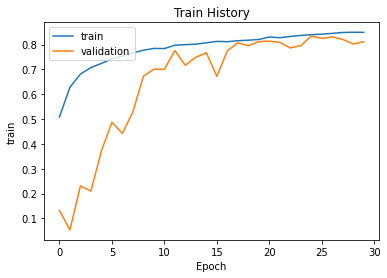

In [ ]:
#------------   Plot the Training accuracy and validation Accuracy -------------------
def show_train_history(train_history,train_accuracy,val_accuracy):
        plt.plot(train_history.history[train_accuracy])
        plt.plot(train_history.history[val_accuracy])
        plt.title('Train History')
        plt.ylabel('train')
        plt.xlabel('Epoch')
        plt.legend(['train','validation'],loc='upper left')
        plt.show()

show_train_history(train_history,'accuracy','val_accuracy') #acc:accuracy for training set. val_acc:accuracy for validation.

## Prediction

In [ ]:
#----------------- Test Predict (as this test images were from the training data) ----------------
prediction  = model.predict(X_test)
print(prediction)

[[3.8942021e-01 6.1182240e-05 3.5979290e-05 ... 2.9689360e-05
  2.0410587e-05 1.6850759e-05]
 [7.2243840e-01 1.5166262e-04 4.2175157e-05 ... 9.2119713e-05
  1.8521653e-04 7.9167461e-05]
 [8.2544424e-02 1.3106309e-03 1.1049936e-03 ... 1.5938759e-03
  1.5750041e-03 1.2497115e-03]
 ...
 [6.7326427e-02 2.1019175e-03 1.3153214e-03 ... 1.6735411e-03
  3.5826922e-03 2.1813107e-03]
 [9.4676744e-03 3.0982145e-04 2.3014226e-04 ... 2.3042755e-04
  1.4015178e-04 3.3933701e-04]
 [4.6526358e-04 9.6804597e-06 1.7424078e-05 ... 1.3713173e-05
  1.3746326e-05 4.0158898e-06]]


In [ ]:
32*32*3

3072

In [ ]:
print(f"{prediction.shape}, {prediction[0]}")

(4000, 351), [3.89420211e-01 6.11822397e-05 3.59792903e-05 2.72650213e-05
 2.13472274e-04 2.63352140e-05 3.95469251e-05 2.20793809e-05
 7.40749010e-06 2.16314933e-04 1.27025341e-04 5.11865073e-05
 4.04498678e-05 5.21643706e-05 1.14916802e-05 2.45342235e-05
 1.50809874e-05 6.82004320e-05 4.24354294e-05 7.79402762e-06
 3.53896758e-05 3.87749533e-05 8.30307545e-05 3.33457683e-05
 2.39211149e-05 5.69881522e-05 3.42486856e-05 1.77866332e-05
 4.34731337e-05 5.20010108e-05 2.87240109e-05 2.83852769e-05
 1.35966029e-05 2.13118838e-05 2.89311356e-05 2.63738220e-05
 6.37499179e-05 4.11799883e-05 2.98285941e-05 3.52865209e-05
 2.56697276e-05 1.83330849e-05 2.17567340e-05 1.36317121e-05
 3.13684723e-05 1.98474008e-05 3.87803884e-05 1.60101008e-05
 5.13275809e-05 1.40088068e-05 1.60424861e-05 3.39717590e-05
 2.05540036e-05 1.02361300e-05 1.28731162e-05 1.73587214e-05
 1.42635445e-05 3.19896935e-05 8.78595529e-06 8.38606411e-06
 4.42359997e-05 1.23856116e-05 2.09024056e-05 5.36015759e-05
 1.52736666

In [ ]:
test_images

,height,id,seq_id,location,width,datetime,file_name,seq_frame_num,seq_num_frames,sub_location
0,1024,8b31d3be-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,2013-06-09 16:01:38.000,8b31d3be-21bc-11ea-a13a-137349068a90.jpg,0,10,NaN
1,1024,8cf202be-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,2013-06-09 16:01:39.000,8cf202be-21bc-11ea-a13a-137349068a90.jpg,1,10,NaN
2,1024,8a87e62e-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,2013-06-09 16:01:40.000,8a87e62e-21bc-11ea-a13a-137349068a90.jpg,2,10,NaN
3,1024,8e6994f4-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,2013-06-09 16:01:41.000,8e6994f4-21bc-11ea-a13a-137349068a90.jpg,3,10,NaN
4,1024,948b29e2-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,2013-06-09 16:01:42.000,948b29e2-21bc-11ea-a13a-137349068a90.jpg,4,10,NaN
...,...,...,...,...,...,...,...,...,...,...
60024,1024,981aabf0-21bc-11ea-a13a-137349068a90,a91b0b90-0cd3-11eb-bed1-0242ac1c0002,5,1280,2013-04-23 00:38:35.000,981aabf0-21bc-11ea-a13a-137349068a90.jpg,0,5,1.0
60025,1024,971d8466-21bc-11ea-a13a-137349068a90,a91b0b90-0cd3-11eb-bed1-0242ac1c0002,5,1280,2013-04-23 00:38:36.000,971d8466-21bc-11ea-a13a-137349068a90.jpg,1,5,1.0
60026,1024,90f05d20-21bc-11ea-a13a-137349068a90,a91b0b90-0cd3-11eb-bed1-0242ac1c0002,5,1280,2013-04-23 00:38:37.000,90f05d20-21bc-11ea-a13a-137349068a90.jpg,2,5,1.0
60027,1024,903c3ebc-21bc-11ea-a13a-137349068a90,a91b0b90-0cd3-11eb-bed1-0242ac1c0002,5,1280,2013-04-23 00:38:37.000,903c3ebc-21bc-11ea-a13a-137349068a90.jpg,3,5,1.0


In [ ]:
#--------------------- test the original test data------------------------
images = test_images.id[:20000]
# test_img_id =test_images.id[:30000]

test_image = []
for i in images:
    img = cv.imread("/kaggle/input/iwildcam2022-fgvc9/test/test/"+ i +".jpg")
    res_img = cv.resize(img, (32,32),interpolation=cv.INTER_AREA)
    test_image.append(res_img)

# Convert it into the numpy array
test_image = np.array(test_image)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: p

In [ ]:
# -------- Predicting the original Test data------------
test_prediction = model.predict(test_image)

In [ ]:
test_prediction

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
test_prediction.shape

(20000, 351)

In [ ]:
data = {"lists": list(images)}
submit = pd.DataFrame({'Id':images,'Predicted': list(test_prediction)})
submit.to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv("/kaggle/working/submission.csv")

,Id,Predicted
0,8b31d3be-21bc-11ea-a13a-137349068a90,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1,8cf202be-21bc-11ea-a13a-137349068a90,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2,8a87e62e-21bc-11ea-a13a-137349068a90,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3,8e6994f4-21bc-11ea-a13a-137349068a90,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4,948b29e2-21bc-11ea-a13a-137349068a90,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
...,...,...
19995,93aa9c1a-21bc-11ea-a13a-137349068a90,[2.0193081e-15 0.0000000e+00 0.0000000e+00 0.0...
19996,95580caa-21bc-11ea-a13a-137349068a90,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
19997,97f4be7c-21bc-11ea-a13a-137349068a90,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
19998,95bb8dc0-21bc-11ea-a13a-137349068a90,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
